In [1]:
import torch
from torchvision import datasets, transforms
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# from binarized_modules import  BinarizeLinear,BinarizeConv2d

In [2]:
import models.cim_fc as cim_fc
import models.cim_conv as cim_conv
import models.binarized_modules as binarized_modules

In [3]:
import importlib

In [4]:
importlib.reload(binarized_modules)
importlib.reload(cim_conv)
importlib.reload(cim_fc)

<module 'models.cim_fc' from '/shares/bulk/earapidis/dev/BinarizedNN/models/cim_fc.py'>

In [5]:
from models.lenet_5 import BinarizedLeNet5_BN as Lenet_5

In [6]:
cuda = True

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [8]:
test_batch_size=1000

In [9]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [10]:
# from models.mlp import MLP,MLP_CIM
# model_idx = 2
# models_path = os.path.abspath(f"/shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_{model_idx}")
# model_path = os.path.join(models_path,f"best.pth")

# model = MLP()
# model.load_state_dict(torch.load(model_path))
# if cuda:
#     torch.cuda.set_device(0)
#     model.cuda()

In [11]:
from models.lenet_5 import BinarizedLeNet5_BN as Lenet_5
from models.lenet_5 import BinarizedLeNet5_BN_CIM as Lenet_5_CIM

model_idx = 1
models_path = os.path.abspath(f"/shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_{model_idx}")
model_path = os.path.join(models_path,f"best.pth")
model = Lenet_5()
model.load_state_dict(torch.load(model_path))
if cuda:
    torch.cuda.set_device(0)
    model.cuda()

In [12]:
modules_hooks = ['pool1', 'pool2',"htanh3","htanh4"]
modules_hooks_remap_names=["conv2","fc1","fc2","fc3"]

In [13]:
model.eval()  # put in eval mode

features = {}
with torch.no_grad():
    conv1_features = []
    for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader)):
        conv1_features.extend(inputs)
conv1_features = torch.stack(conv1_features)
features["conv1"]=conv1_features

def make_hook(name):
    def hook(module, inp, out):
        # detach so you don’t keep the entire computation graph
        features.setdefault(name, []).append(out.detach().cpu())
    return hook

# Register hooks on whichever layers you care about
handles = []
for idx,hook_name in enumerate(modules_hooks):  # replace with your layer names
    module = dict(model.named_modules())[hook_name]
    layer_name = modules_hooks_remap_names[idx]
    handles.append(module.register_forward_hook(make_hook(layer_name)))

# 2) Run through your test_loader
with torch.no_grad():
    for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader)):
        inputs = inputs.cuda()
        # forward pass — hooks will fire automatically
        outputs = model(inputs)

        # (optional) compute loss/accuracy here
        # loss = F.cross_entropy(outputs, targets.to(device))
        # ...

# 3) Process your collected features
# e.g. concatenate per‑batch outputs into one big tensor per layer


for name, acts in features.items():
    if name=="fc1":

        fc_x = torch.cat(acts, dim=0)
        fc_x = fc_x.view(fc_x.size(0), -1)
        features[name] = fc_x
    elif name!="conv1":
        features[name] = torch.cat(acts, dim=0)  # shape (num_samples, ...)

print("Collected features:")
for name, tensor in features.items():
    print(f"  {name:6s}: {tensor.shape}")

# 4) Clean up your hooks
for h in handles:
    h.remove()


10it [00:02,  3.48it/s]
10it [00:02,  3.34it/s]

Collected features:
  conv1 : torch.Size([10000, 1, 28, 28])
  conv2 : torch.Size([10000, 6, 12, 12])
  fc1   : torch.Size([10000, 256])
  fc2   : torch.Size([10000, 120])
  fc3   : torch.Size([10000, 84])


In [14]:
Num_rows = 32
Num_columns = 32

In [15]:
x = features["fc1"]
w = model.fc1.weight.data.detach()

In [16]:
x.shape

torch.Size([10000, 256])

In [17]:
w.shape

torch.Size([120, 256])

In [18]:
def conv_map_to_cim(x,w,Num_rows,Num_columns,mapping,checkboard,padding=0):
    x = binarized_modules.binarized(x)
    w = binarized_modules.binarized(w)

    if mapping:
        mapped_x, mapped_w = cim_conv.map_conv2d(x,w,padding=padding)
        crossbar_inputs = cim_conv.get_inputs_to_cim(mapped_x,Num_rows)
        crossbar_weights = cim_conv.get_weights_to_cim(mapped_w,Num_rows,Num_columns,checkboard)
    else:
        (pos_x,pos_w), (neg_x,neg_w) = cim_conv.map_conv2d_regular_mapping(x,w,padding=padding)
        pos_x = cim_conv.get_inputs_to_cim(pos_x,Num_rows)
        neg_x = cim_conv.get_inputs_to_cim(neg_x,Num_rows)
        pos_w = cim_conv.get_weights_to_cim(pos_w,Num_rows,Num_columns,checkboard)
        neg_w = cim_conv.get_weights_to_cim(neg_w,Num_rows,Num_columns,checkboard)
        crossbar_inputs = (pos_x,neg_x)
        crossbar_weights = (pos_w,neg_w)
    return (crossbar_inputs,crossbar_weights)

In [19]:
def fc_map_to_cim(x,w,Num_rows,Num_columns,mapping,checkboard):
    x = binarized_modules.binarized(x)
    w = binarized_modules.binarized(w)
    if mapping:
        mapped_x, mapped_w = cim_fc.map_fc(x,w)
        crossbar_inputs = cim_fc.get_inputs_to_cim(mapped_x,Num_rows)
        crossbar_weights = cim_fc.get_weights_to_cim(mapped_w,Num_rows,Num_columns,checkboard)
    else:
        pos_x, neg_x = cim_conv.compliment(x)
        pos_x = cim_fc.get_inputs_to_cim(pos_x,Num_rows)
        neg_x = cim_fc.get_inputs_to_cim(neg_x,Num_rows)
        crossbar_inputs = (pos_x,neg_x)

        pos_w, neg_w = cim_conv.compliment(w)
        pos_w = cim_fc.get_weights_to_cim(pos_w,Num_rows,Num_columns,checkboard)
        neg_w = cim_fc.get_weights_to_cim(neg_w,Num_rows,Num_columns,checkboard)
        crossbar_weights = (pos_w,neg_w)
    return (crossbar_inputs,crossbar_weights)


In [20]:
def conv_get_fraction_inputs(x):
    _N_, _Hout_, _Wout_, crossbar_y, Num_rows = x.shape
    x = x.float().mean(dim=-1)
    x = x.flatten()
    return x

def fc_get_fraction_inputs(x):
    _N_, crossbar_y, Num_rows = x.shape
    x = x.float().mean(dim=-1)
    x = x.flatten()
    return x

def get_fraction_weights(w):
    crossbar_y,crossbar_x, Num_rows, Num_columns = w.shape
    w = w.float().mean(dim=(-2,-1))
    w = w.flatten()
    return w

In [21]:
# mapping = True
# w = w.T
# crossbar_inputs, crossbar_weights = fc_map_to_cim(x,w,Num_rows,Num_columns,mapping=mapping,checkboard=mapping,padding=0)


In [22]:
# crossbar_inputs.shape

In [23]:
# crossbar_weights.shape

In [24]:
def get_fractions(x,w,model_type,Num_rows,Num_columns,mapping,checkboard):
    if model_type=="fc":
        w = w.T
        crossbar_inputs, crossbar_weights = fc_map_to_cim(x,w,Num_rows,Num_columns,mapping=mapping,checkboard=checkboard)
    elif model_type=="conv":
        crossbar_inputs, crossbar_weights = conv_map_to_cim(x,w,Num_rows,Num_columns,mapping=mapping,checkboard=checkboard,padding=0)
    else:
        raise Exception(f"Unsupported model type {model_type}")

    if mapping:
        if model_type=="fc":
            input_fractions = fc_get_fraction_inputs(crossbar_inputs)
        else:
            input_fractions = conv_get_fraction_inputs(crossbar_inputs)
        weight_fractions = get_fraction_weights(crossbar_weights)
    else:
        (pos_x,neg_x) = crossbar_inputs
        (pos_w,neg_w) = crossbar_weights
        if model_type=="fc":
            pos_x = fc_get_fraction_inputs(pos_x)
            neg_x = fc_get_fraction_inputs(neg_x)
        else:
            pos_x = conv_get_fraction_inputs(pos_x)
            neg_x = conv_get_fraction_inputs(neg_x)

        pos_w = get_fraction_weights(pos_w)
        neg_w = get_fraction_weights(neg_w)

        input_fractions = torch.cat((pos_x,neg_x))
        weight_fractions = torch.cat((pos_w,neg_w))
    return input_fractions,weight_fractions


In [25]:
features.keys()

dict_keys(['conv1', 'conv2', 'fc1', 'fc2', 'fc3'])

In [26]:
mapping = False

In [27]:
model_type = "fc"
input_fractions,weight_fractions = get_fractions(x,w,model_type,Num_rows,Num_columns,mapping=mapping,checkboard=mapping)

In [28]:
torch.unique(weight_fractions,return_counts=True)

(tensor([0.4297, 0.4336, 0.4346, 0.4385, 0.4395, 0.4414, 0.4443, 0.4473, 0.4482,
         0.4492, 0.4512, 0.4521, 0.4541, 0.4551, 0.4580, 0.4590, 0.4609, 0.4619,
         0.4639, 0.4658, 0.4668, 0.4678, 0.4697, 0.4707, 0.4717, 0.4736, 0.4756,
         0.4766, 0.4785, 0.4795, 0.4824, 0.4834, 0.4854, 0.4863, 0.4883, 0.4893,
         0.4902, 0.4932, 0.4961, 0.4980, 0.4990, 0.5029, 0.5039, 0.5078]),
 tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 4, 3, 1, 1, 2, 1, 1, 1, 1, 1,
         1, 2, 1, 1, 3, 4, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1]))

In [29]:
torch.unique(input_fractions,return_counts=True)


(tensor([0.0625, 0.0938, 0.1250, 0.1562, 0.1875, 0.2188, 0.2500, 0.2812, 0.3125,
         0.3438, 0.3750, 0.4062, 0.4375, 0.4688, 0.5000, 0.5312, 0.5625, 0.5938,
         0.6250, 0.6562, 0.6875, 0.7188, 0.7500, 0.7812, 0.8125, 0.8438, 0.8750,
         0.9062, 0.9375]),
 tensor([    2,     2,    18,   100,   433,   939,  1742,  2873,  4897,  7849,
         10791, 13170, 14729, 14987, 14936, 14987, 14729, 13170, 10791,  7849,
          4897,  2873,  1742,   939,   433,   100,    18,     2,     2]))

(array([2.0000e+00, 2.0000e+00, 0.0000e+00, 1.8000e+01, 0.0000e+00,
        1.0000e+02, 0.0000e+00, 4.3300e+02, 9.3900e+02, 0.0000e+00,
        1.7420e+03, 0.0000e+00, 2.8730e+03, 0.0000e+00, 4.8970e+03,
        0.0000e+00, 7.8490e+03, 1.0791e+04, 0.0000e+00, 1.3170e+04,
        0.0000e+00, 1.4729e+04, 0.0000e+00, 1.4987e+04, 0.0000e+00,
        1.4936e+04, 1.4987e+04, 0.0000e+00, 1.4729e+04, 0.0000e+00,
        1.3170e+04, 0.0000e+00, 1.0791e+04, 7.8490e+03, 0.0000e+00,
        4.8970e+03, 0.0000e+00, 2.8730e+03, 0.0000e+00, 1.7420e+03,
        0.0000e+00, 9.3900e+02, 4.3300e+02, 0.0000e+00, 1.0000e+02,
        0.0000e+00, 1.8000e+01, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([0.0625    , 0.08      , 0.0975    , 0.115     , 0.13249999,
        0.15000001, 0.1675    , 0.185     , 0.2025    , 0.22      ,
        0.2375    , 0.255     , 0.27250001, 0.28999999, 0.3075    ,
        0.32499999, 0.3425    , 0.36000001, 0.3775    , 0.39500001,
        0.41249999, 0.43000001, 0.44749999, 0.

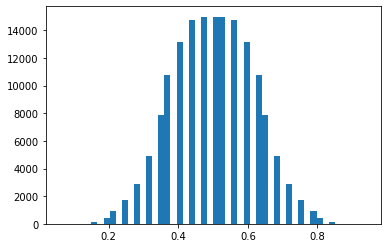

In [30]:
plt.hist(input_fractions,bins=50)

In [31]:
from scipy import stats
kde = stats.gaussian_kde(input_fractions)

In [32]:
import random
num_samples = 10000
random_indices = random.sample(range(input_fractions.numel()), num_samples)
sampled_fractions = input_fractions[random_indices]
sampled_kde = kde.resample(num_samples)
sampled_kde = sampled_kde.squeeze()


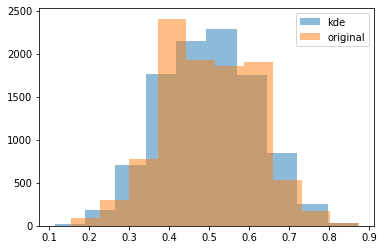

In [33]:
bins = 10
plt.hist(sampled_kde,label="kde",alpha=0.5,bins=bins)
plt.hist(sampled_fractions,label="original",alpha=0.5,bins=bins)
plt.legend()

In [34]:
features.keys()

dict_keys(['conv1', 'conv2', 'fc1', 'fc2', 'fc3'])

In [35]:
mapping = False
_x_fractions_ = []
_w_fractions_ = []
for module_name, x in tqdm(features.items()):

    module = dict(model.named_modules())[module_name]
    w = module.weight.data.detach()
    if "fc" in module_name:
        model_type = "fc"
    elif "conv" in module_name:
        model_type = "conv"
    input_fractions,weight_fractions = get_fractions(x,w,model_type,Num_rows,Num_columns,mapping=mapping,checkboard=mapping)
    _x_fractions_.extend(input_fractions)
    _w_fractions_.extend(weight_fractions)

100%|██████████| 5/5 [00:45<00:00,  9.12s/it]


In [45]:
x_fractions = torch.tensor(_x_fractions_)
w_fractions = torch.tensor(_w_fractions_)
print(x_fractions.shape)
print(w_fractions.shape)

torch.Size([18220000])
torch.Size([106])


In [95]:
class PicklableKDE(stats.gaussian_kde):
    def __init__(self, dataset, bw):
        # Initialize *without* calling set_bandwidth
        super().__init__(dataset, bw_method=None)
        # store your bandwidth
        self._fixed_bw = bw
        # manually compute covariance with your fixed bw
        self._compute_covariance()

    def covariance_factor(self):
        # this is called by gaussian_kde internally
        return self._fixed_bw

In [114]:
x_fractions = x_fractions[torch.where(x_fractions!=0)]

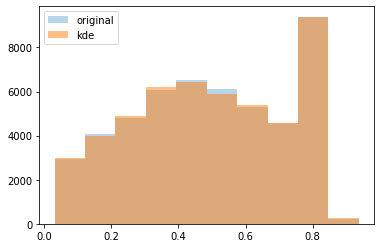

In [115]:
x_kde = stats.gaussian_kde(x_fractions,bw_method=0.000001)

num_samples = 50000
random_indices = random.sample(range(x_fractions.numel()), num_samples)
sampled_fractions = x_fractions[random_indices]
sampled_kde = x_kde.resample(num_samples)
sampled_kde = sampled_kde.squeeze()
bins = 10
plt.hist(sampled_fractions,label="original",alpha=0.3,bins=bins)
plt.hist(sampled_kde,label="kde",alpha=0.5,bins=bins)
plt.legend()

In [117]:
w_fractions = w_fractions[torch.where(w_fractions!=0)]


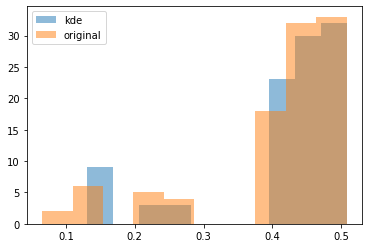

In [119]:
w_kde = stats.gaussian_kde(w_fractions,bw_method=0.0001)

num_samples = 100
random_indices = random.sample(range(w_fractions.numel()), num_samples)
sampled_fractions = w_fractions[random_indices]
sampled_kde = w_kde.resample(num_samples)
sampled_kde = sampled_kde.squeeze()
bins = 10
plt.hist(sampled_kde,label="kde",alpha=0.5,bins=bins)
plt.hist(sampled_fractions,label="original",alpha=0.5,bins=bins)
plt.legend()

In [120]:
import pickle
import dill

model_idx = 1
models_dir = os.path.abspath(f"/shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_{model_idx}")

x_kde_path = os.path.join(models_dir,"x_kde.pkl")
w_kde_path = os.path.join(models_dir,"w_kde.pkl")

with open(x_kde_path,"wb") as f:
    dill.dump(x_kde,f)

with open(w_kde_path,"wb") as f:
    dill.dump(w_kde,f)
